In [ ]:
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
from matplotlib import pyplot as plt
import fastcore.all as fc
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset
from minai.datasets import inplace
from minai.conv import conv
from minai.learner import DataLoaders, MomentumLearner, DeviceCB, ProgressCB, LRFinderCB, MetricsCB, Callback
from minai.activations import ActivationStats, set_seed, Hook
from math import sqrt
from functools import partial

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
set_seed(42)

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
x1, y1 = 'image', 'label'
ds = load_dataset('fashion_mnist'); ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
@inplace
def transformi(b): b[x1] = [TF.to_tensor(o) for o in b[x1]]
dsd = ds.with_transform(transformi)

In [ ]:
ds['train'][x1][0]

In [ ]:
dsd['train'][x1][0].shape

torch.Size([1, 28, 28])

In [ ]:
bs = 1024
dls = DataLoaders.from_dd(dsd, bs)

In [ ]:
dt = dls.train

In [ ]:
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
def get_model():
    return nn.Sequential(conv(1, 8), 
                        conv(8, 16), 
                        conv(16, 32), 
                        conv(32, 64), 
                        conv(64, 10, act=False),
                        nn.Flatten())

In [ ]:
model = get_model()
lr_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB(gamma=1.1)]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-2, cbs=lr_cbs)

In [ ]:
learn.fit(1)

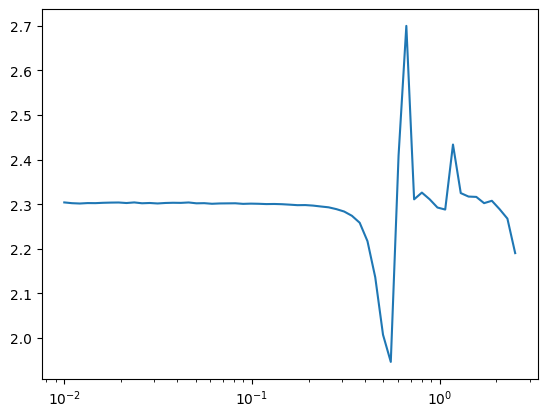

In [ ]:
learn.cbs[-1].plot()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), astats, metrics]
model = get_model()
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

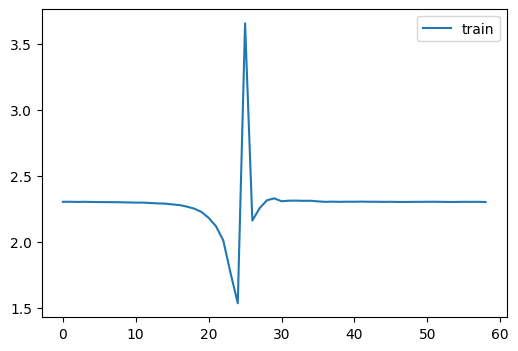

In [ ]:
learn.fit(1)

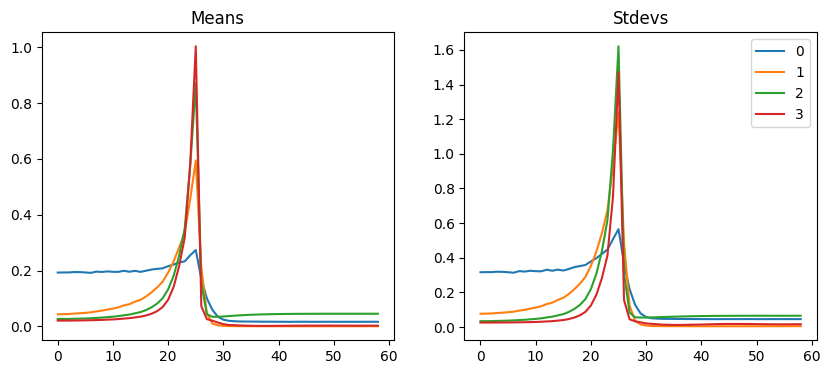

In [ ]:
astats.plot_stats()

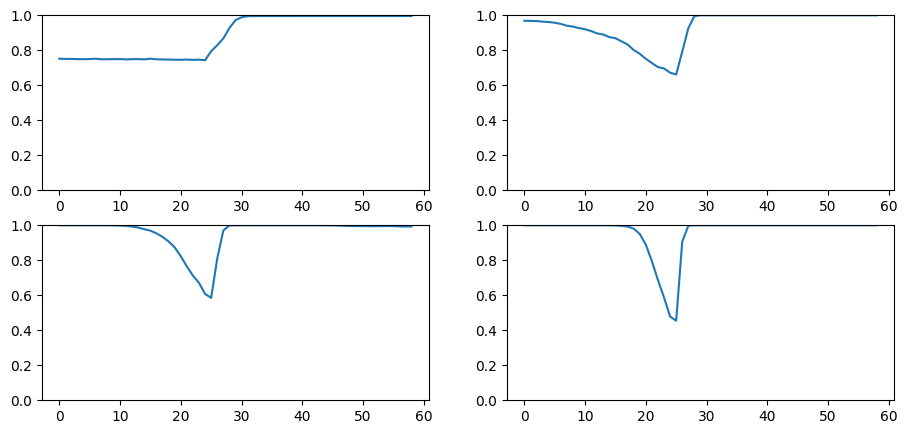

In [ ]:
astats.dead_chart()

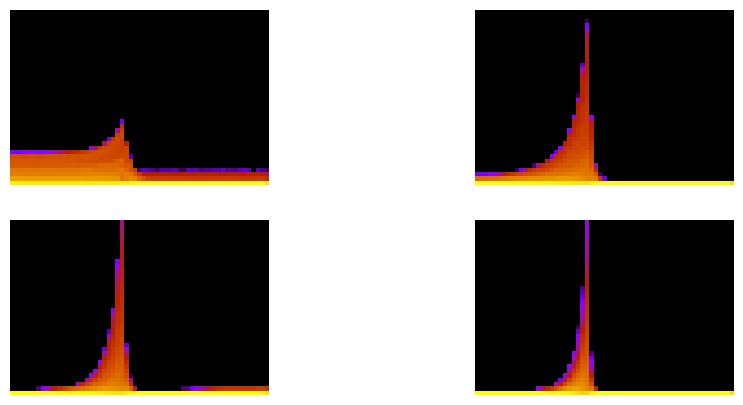

In [ ]:
astats.color_dim()

## Xavier Initialization

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[:5, :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100) * 0.01
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100) * 0.1 
x[:5, :5]

tensor([[-0.24, -0.20,  1.21, -0.63, -0.50],
        [-0.05, -0.15, -0.06, -0.11, -0.13],
        [-1.22, -0.06, -1.84,  0.24, -0.29],
        [-1.55, -0.18, -0.65,  0.00, -0.24],
        [ 0.34, -0.11,  1.33, -0.49, -0.45]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = torch.tanh(x @ torch.randn(100, 100) * 0.1)
x[:5, :5]

tensor([[ 0.01, -0.11, -0.11, -0.21,  0.10],
        [ 0.05, -0.11, -0.01, -0.09,  0.20],
        [-0.12, -0.07, -0.14, -0.01, -0.10],
        [ 0.06,  0.05,  0.07,  0.07, -0.02],
        [ 0.01,  0.00,  0.06,  0.04,  0.16]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = torch.tanh(x @ torch.randn(100, 100)) # the values are getting squashed
x[:5, :5]

tensor([[-1.00, -1.00, -1.00,  1.00,  0.99],
        [ 1.00,  1.00, -1.00, -1.00,  1.00],
        [ 1.00, -1.00,  1.00, -1.00,  1.00],
        [-1.00,  0.81, -1.00,  0.26,  1.00],
        [-1.00,  0.98, -1.00,  0.22,  0.99]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = torch.tanh(x @ torch.randn(100, 100)* 0.01) # the values are getting squashed
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Variance

In [ ]:
t = torch.tensor([1., 2., 4., 18.])

In [ ]:
m = t.mean()

In [ ]:
(t - m).mean()

tensor(0.)

In [ ]:
(t - m).pow(2).mean()

tensor(47.19)

In [ ]:
(t - m).pow(2).mean().sqrt()

tensor(6.87)

In [ ]:
(t - m).abs().mean()

tensor(5.88)

In [ ]:
t.pow(2).mean() - m.pow(2)

tensor(47.19)

## Covariance

In [ ]:
u = t * 2  

In [ ]:
u

tensor([ 2.,  4.,  8., 36.])

In [ ]:
u *= torch.rand_like(t)/10 + 0.95

<matplotlib.collections.PathCollection>

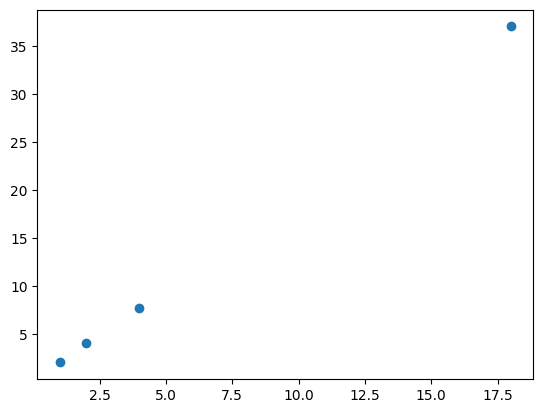

In [ ]:
plt.scatter(t, u, )

In [ ]:
cov = ((t - t.mean()) * (u - u.mean())).mean(); cov

tensor(97.30)

In [ ]:
cov / (t.std() * u.std()) # correlation; standarized version of covariance

tensor(0.75)

In [ ]:
u = torch.rand_like(t)

<matplotlib.collections.PathCollection>

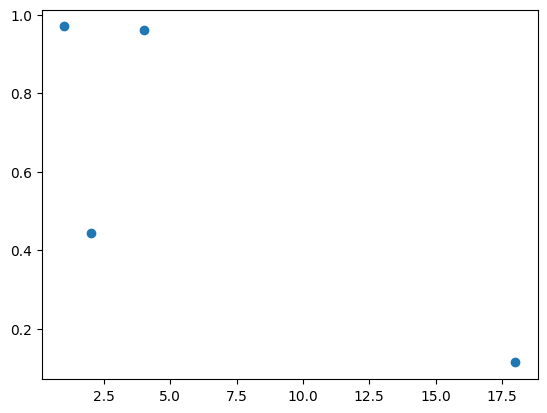

In [ ]:
plt.scatter(t, u)

In [ ]:
cov = ((t - t.mean()) * (u - u.mean())).mean(); cov

tensor(-1.95)

In [ ]:
cov / (t.std() * u.std())

tensor(-0.59)

In [ ]:
(t * u).mean() - (t.mean() * u.mean())

tensor(-1.95)

## Xavier Initialization Derivation

In [ ]:
m = 0
s = 0
for i in range(100):
    a = torch.randn(200, 100)
    x = torch.randn(100)
    y = (a @ x)
    m += y.mean()
    s += y.pow(2).mean().sqrt()
m/100, s/100 * (1/10) # 1/sqrt(nl) is (1/10) which get multiplied

(tensor(0.06), tensor(1.00))

In [ ]:
m = 0
s = 0
for i in range(100):
    a = torch.randn(1)
    x = torch.randn(1)
    y = a @ x
    m += y.mean()
    s += y.pow(2).mean()
m/100, s/100     

(tensor(0.06), tensor(0.94))

## Kaiming Initialization

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = torch.relu(x @ torch.randn(100, 100) * 0.1)
x[:5, :5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = torch.relu(x @ (torch.randn(100, 100) * sqrt(2/100)))
x[:5, :5]

tensor([[1.15, 0.06, 0.29, 0.00, 0.00],
        [1.43, 0.04, 0.34, 0.00, 0.00],
        [1.32, 0.00, 0.33, 0.00, 0.00],
        [0.96, 0.00, 0.27, 0.00, 0.00],
        [0.96, 0.00, 0.24, 0.00, 0.00]])

In [ ]:
model = get_model()
model.apply(lambda x: print(type(x).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [ ]:
def init_weight(m, leaky=0):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
model = get_model()
model.apply(lambda m: init_weight(m));

In [ ]:
set_seed(42)
lrf_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
learn = MomentumLearner(get_model().apply(init_weight), dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

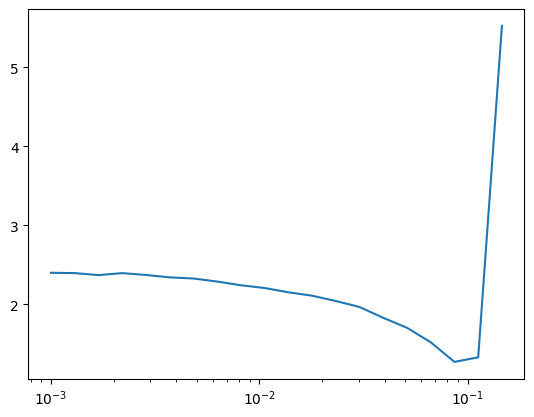

In [ ]:
lrf_cbs[-1].plot()

In [ ]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weight), dls, F.cross_entropy, lr=0.02, cbs=cbs)

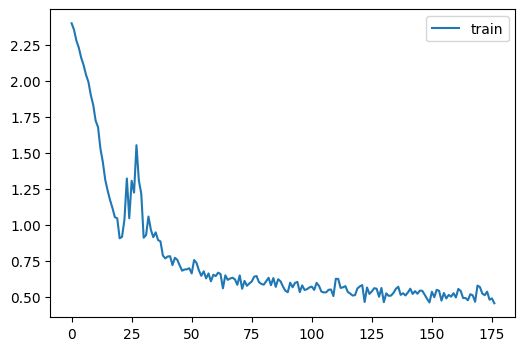

In [ ]:
learn.fit(3)

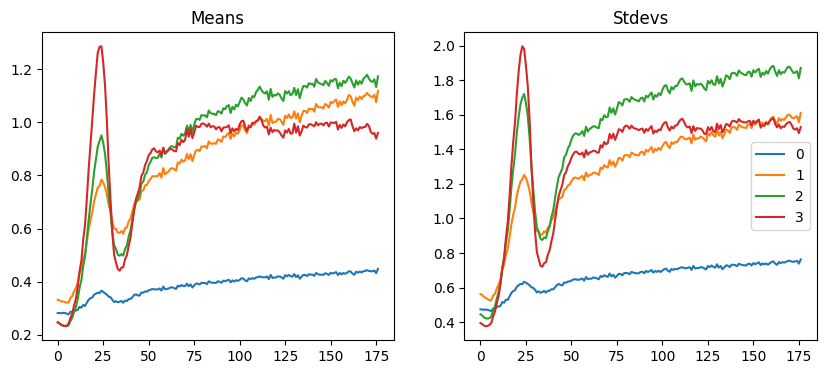

In [ ]:
astats.plot_stats()

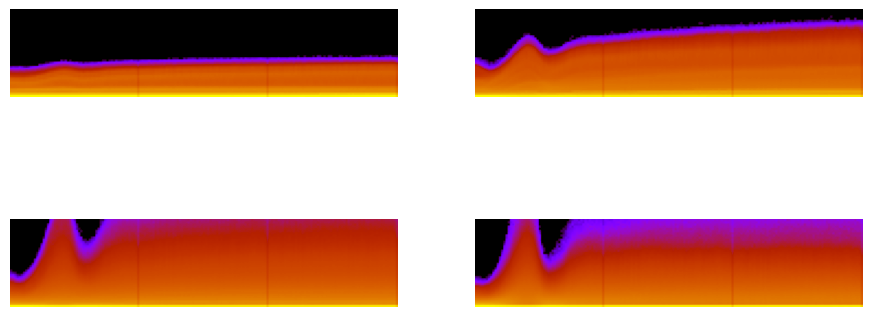

In [ ]:
astats.color_dim()

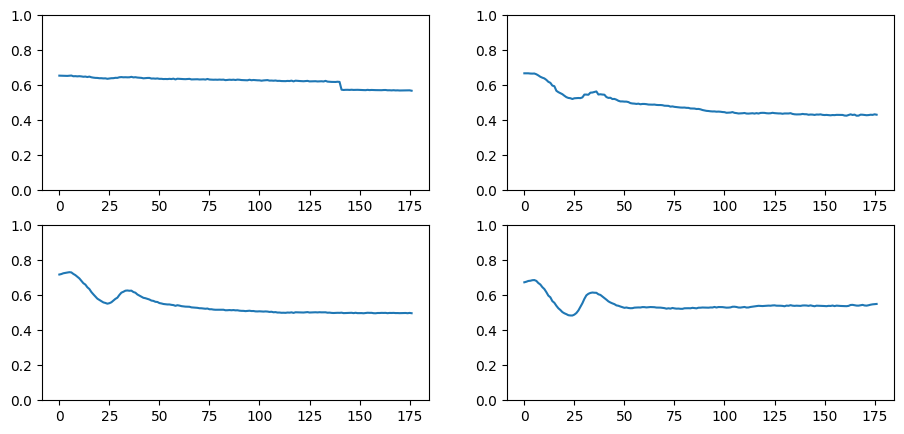

In [ ]:
astats.dead_chart()

In [ ]:
y = torch.tensor([1, 4, 5, 6])

In [ ]:
y.clamp_max(5)

tensor([1, 4, 5, 5])

## General ReLU

In [ ]:
class GeneralReLU(nn.Module):
    def __init__(self, leaky=None, sub=None, maxv=None):
        super().__init__()
        fc.store_attr()
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leaky) if self.leaky else F.relu(x)
        if self.sub: x.sub_(self.sub)
        if self.maxv: x.clamp_max(self.maxv)
        return x

In [ ]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(-5., 5., 100)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

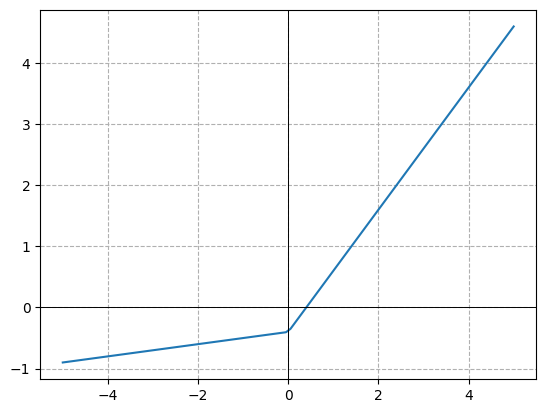

In [ ]:
plot_func(GeneralReLU(leaky=0.1, sub=0.4))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res= nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act, nfs=None):
    if not nfs: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) - 1)]
    layers.extend([conv(nfs[-1], 10, act=False), nn.Flatten()])
    return nn.Sequential(*layers)

In [ ]:
get_model(GeneralReLU)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
act_gr = partial(GeneralReLU, leaky=0.1, sub=0.4)
iw = partial(init_weight, leaky=0.1)
lr_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=1e-3, cbs=lr_cbs)
learn.fit(1)

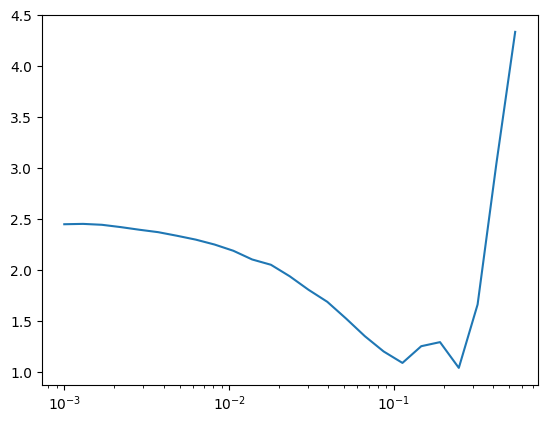

In [ ]:
lr_cbs[-1].plot()

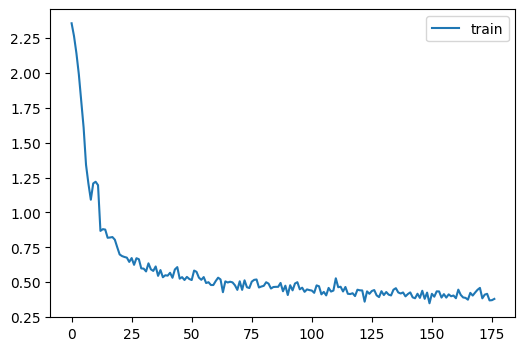

In [ ]:
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats]
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)

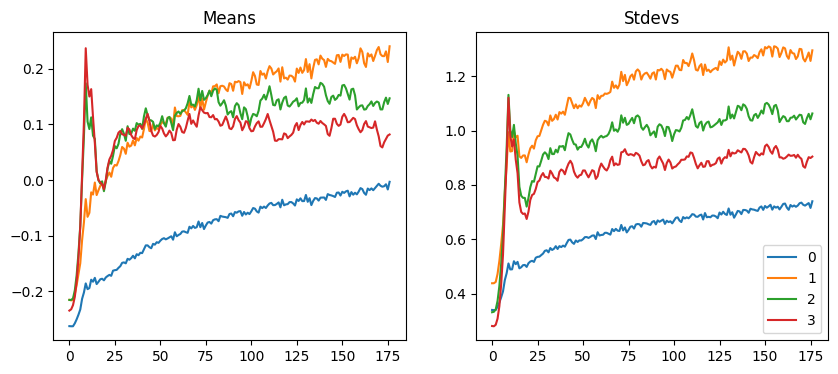

In [ ]:
astats.plot_stats()

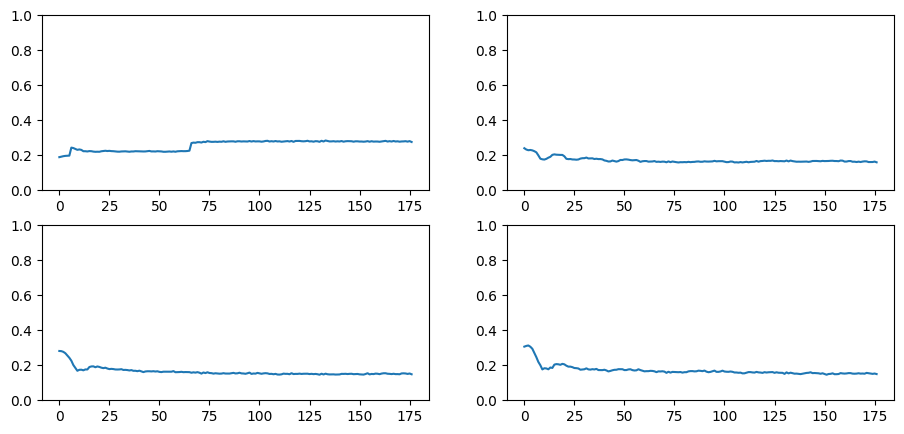

In [ ]:
astats.dead_chart()

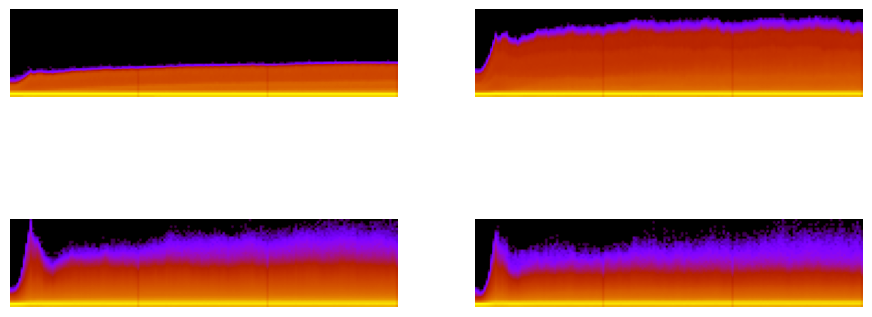

In [ ]:
astats.color_dim()

## BatchNorm

In [ ]:
x_mean, x_std = xb.mean(), xb.std()

In [ ]:
x_mean, x_std

(tensor(0.28), tensor(0.35))

In [ ]:
def _norm(batch):
    return (batch[0] - x_mean) / x_std, batch[1]

In [ ]:
xb, yb = _norm((xb, yb)); xb.mean(), xb.std()

(tensor(    0.00), tensor(1.))

In [ ]:
class BatchNormCB(Callback):
    def __init__(self, norm): self.norm = norm
    def before_batch(self): self.learn.batch = self.norm(self.learn.batch)

In [ ]:
lr_cbs = [DeviceCB(), ProgressCB(plot=True), BatchNormCB(_norm), LRFinderCB()]
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=1e-3, cbs=lr_cbs)
learn.fit(1)

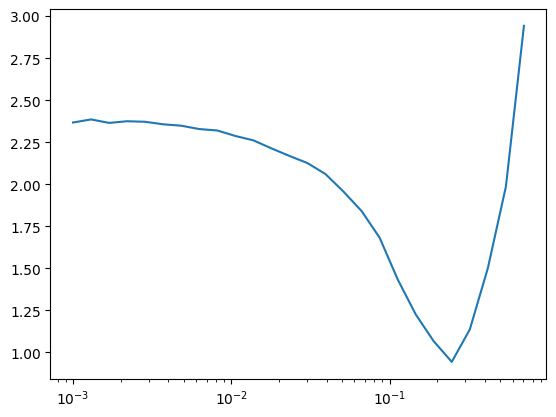

In [ ]:
lr_cbs[-1].plot()

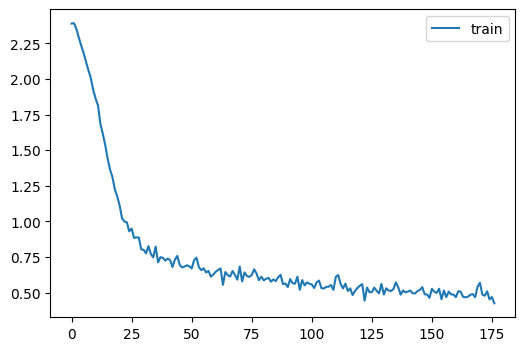

In [ ]:
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), ProgressCB(plot=True), BatchNormCB(_norm), metrics, astats]
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(3)

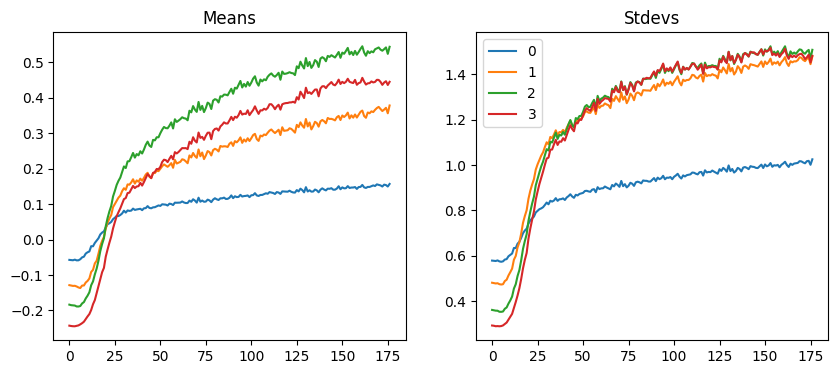

In [ ]:
astats.plot_stats()

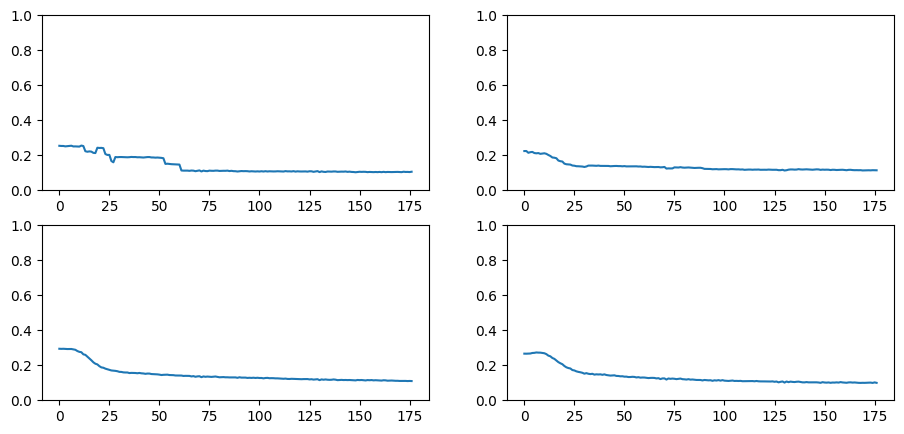

In [ ]:
astats.dead_chart()

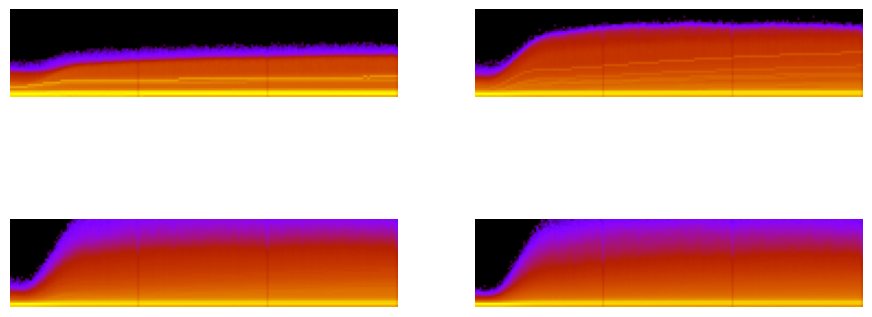

In [ ]:
astats.color_dim()

## LSUV

In [ ]:
model = get_model(act_gr).apply(iw)

In [ ]:
def lsuv_func(hook, m, inp, out):
    hook.mean = out.mean()
    hook.std = out.std()

In [ ]:
def lsuv_init(m_in, m):
    h = Hook(m, lsuv_func)
    with torch.no_grad():
        #print(f'Before {h.mean}, {h.std}')
        while model(xb) is not None and (h.mean > 1e-3 or abs(h.std - 1) > 1e-3):
            m_in.bias -= h.mean
            m_in.weight /= h.std
        print(f'After {h.mean}, {h.std}')
    h.remove()

In [ ]:
convs = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
relus = [m for m in model.modules() if isinstance(m, GeneralReLU)]

In [ ]:
for c, r in zip(convs, relus): lsuv_init(c, r)

After 0.0009585384977981448, 0.999681830406189
After 0.0007791916141286492, 0.999735951423645
After 0.0008923271670937538, 0.9996805787086487
After 0.0007633436471223831, 0.9997331500053406


In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

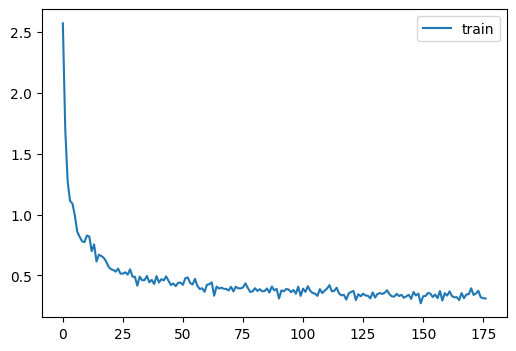

In [ ]:
learn.fit(3)

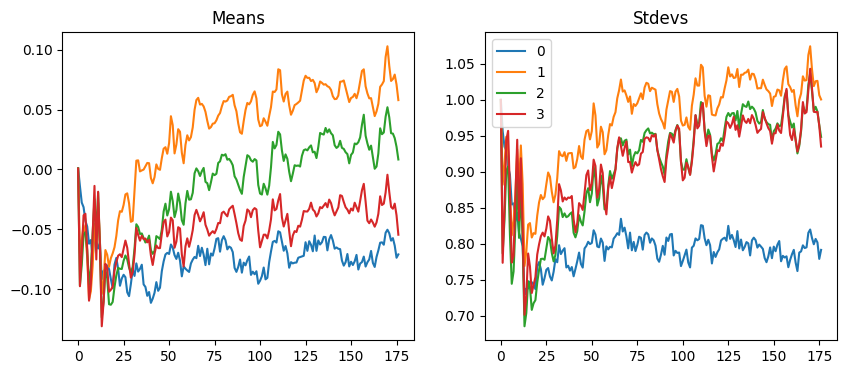

In [ ]:
astats.plot_stats()

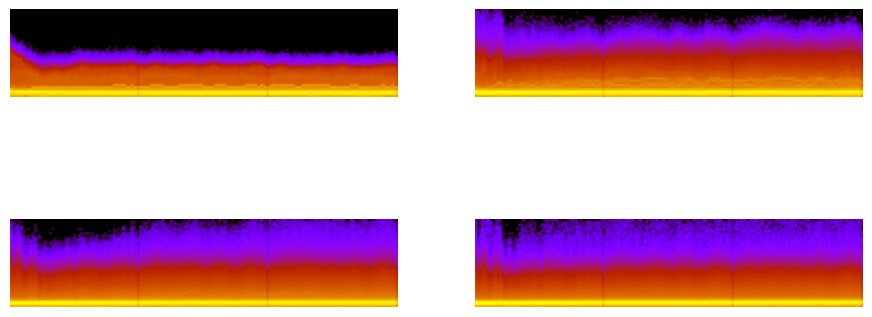

In [ ]:
astats.color_dim()

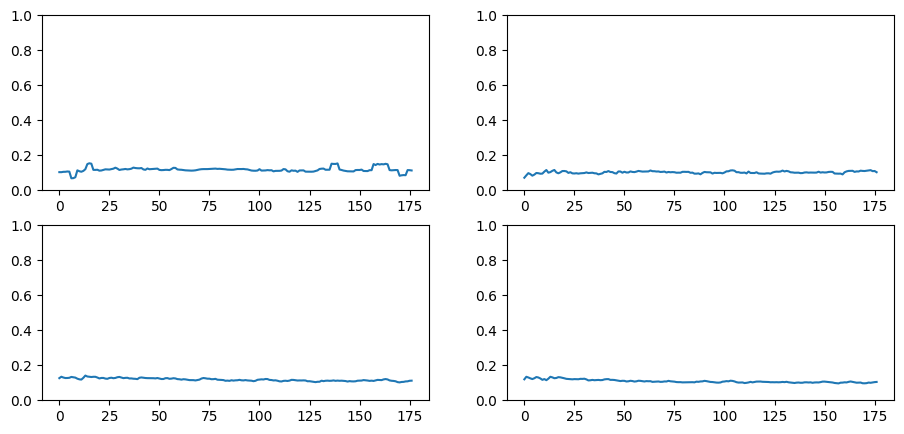

In [ ]:
astats.dead_chart()

## LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.mult = nn.Parameter(torch.ones(1))
        self.add = nn.Parameter(torch.zeros(1))
        
    
    def forward(self, x):
        x_mean = x.mean((1, 2, 3), keepdim=True) # BCHW --> B111
        x_std = x.std((1, 2, 3), keepdim=True) # BCHW --> B111
        x  = (x - x_mean)/ x_std
        return x * self.mult + self.add

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=None, norm=None, bias=True):
    res = nn.Conv2d(ni, nf, ks, stride, ks//2, bias=bias)
    if norm: res = nn.Sequential(res, norm(nf))
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act, norm, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10), nn.Flatten())

In [ ]:
model = get_model(act_gr, LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

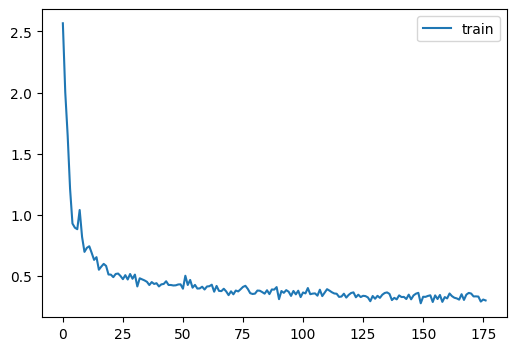

In [ ]:
learn.fit(3)

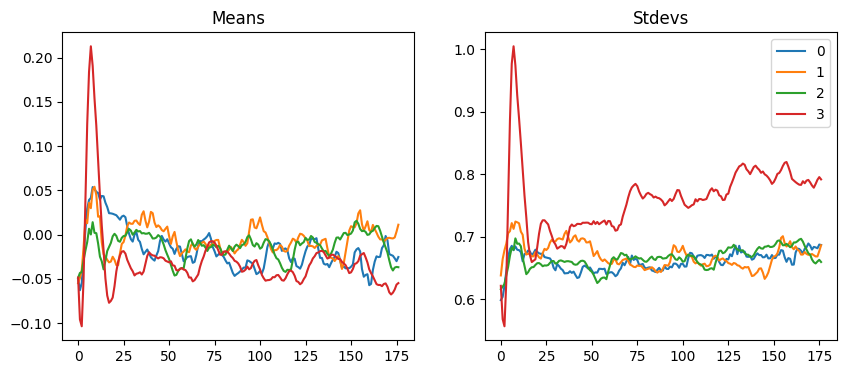

In [ ]:
astats.plot_stats()

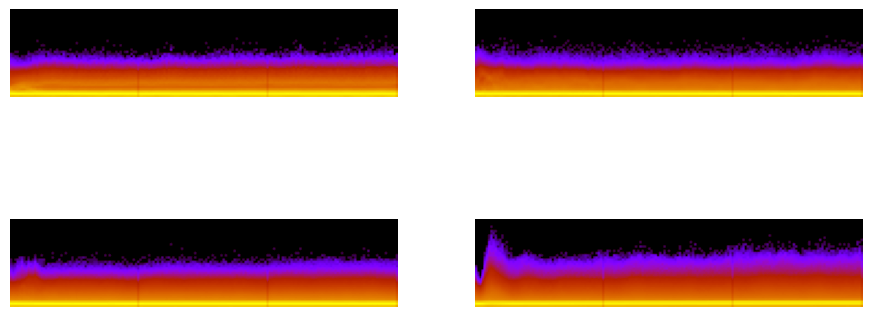

In [ ]:
astats.color_dim()

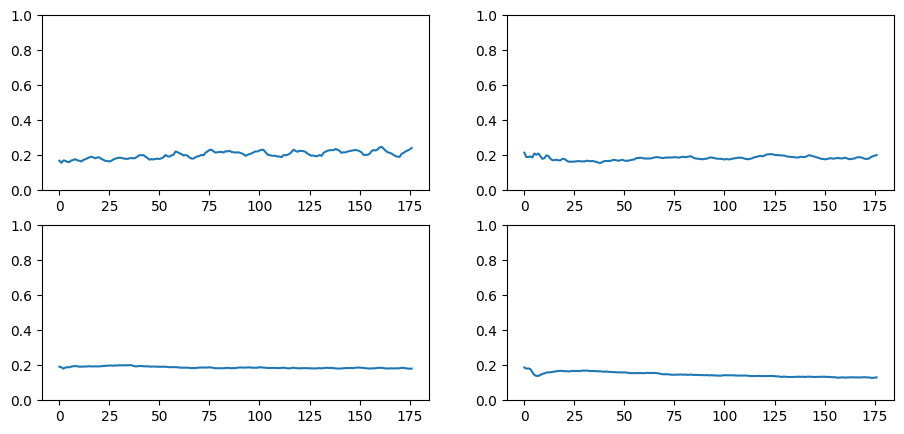

In [ ]:
astats.dead_chart()

## Batch Normalization

In [ ]:
class BatchNormalization(nn.Module):
    def __init__(self, nf, momentum=0.1, eps=1e-3):
        super().__init__()
        fc.store_attr()
        self.mult = nn.Parameter(torch.ones(nf, 1, 1))
        self.add = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('mean', torch.zeros(1, nf, 1, 1))
        self.register_buffer('var', torch.ones(1, nf, 1, 1))
    
    def calculate_stats(self, x):
        m = x.mean((0, 2, 3), keepdims=True) # 1, nf, 1, 1
        v = x.var((0, 2, 3), keepdims=True) # 1, nf, 1, 1
        self.mean.lerp_(m, self.momentum)
        self.var.lerp_(v, self.momentum)
        return m, v
        
    def forward(self, x):
        if self.training:
            m, v = self.calculate_stats(x)
        else:
            m, v = self.mean, self.var
        x  = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.add

In [ ]:
def get_model(act, norm, nfs=None, bias=True):
    if norm == BatchNormalization: bias = False
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm, bias=bias) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10), nn.Flatten())

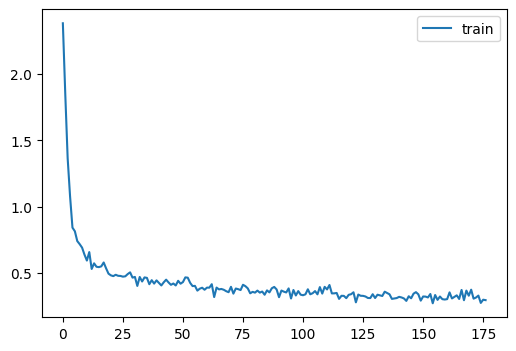

In [ ]:
learn = MomentumLearner(get_model(act_gr, BatchNormalization).apply(iw), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

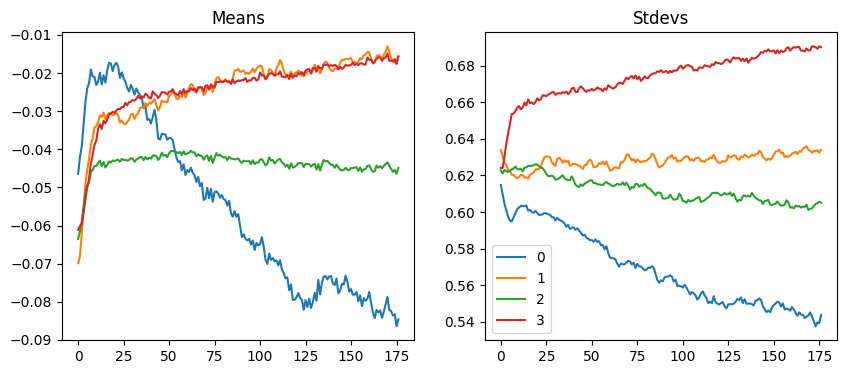

In [ ]:
astats.plot_stats()

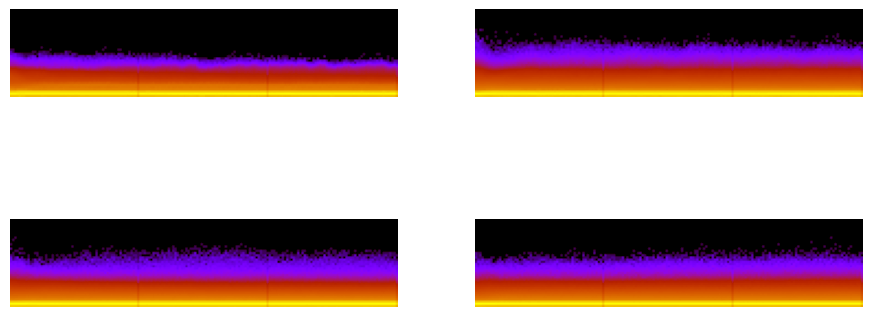

In [ ]:
astats.color_dim()

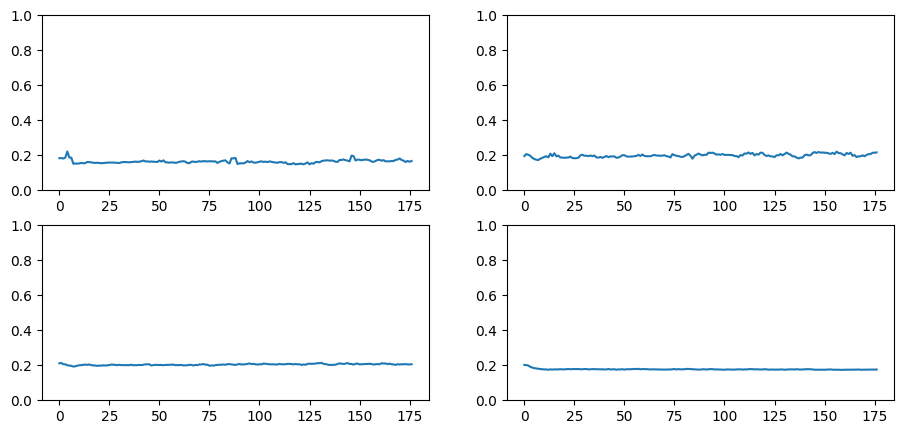

In [ ]:
astats.dead_chart()

## Using PyTorch's BatchNorm2d

In [ ]:
def get_model(act, norm, nfs=None, bias=True):
    if norm in (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d): bias=False
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm, bias=bias) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10), nn.Flatten())

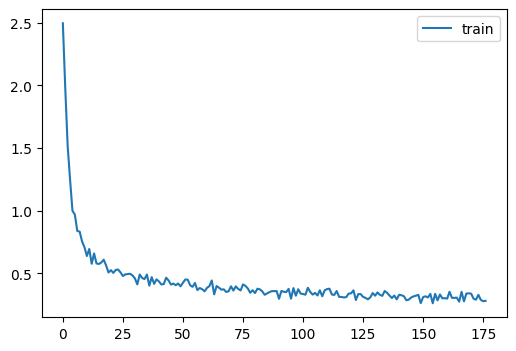

In [ ]:
model = get_model(act_gr, nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.02, cbs=cbs)

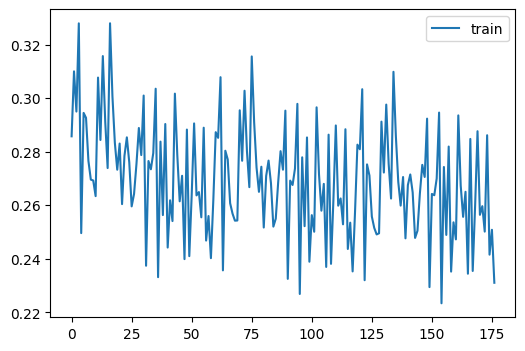

In [ ]:
learn.fit(3)